In [151]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import data.datautil as du

from models import TransformerEncoder, TransformerDecoder

In [152]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [153]:
data_name='Rectifier_oct23_input_constant'
sim_name='RectifierData_step10h' 
dataset_name='RUL_real'

In [163]:
with open(f'./data/{data_name}/dataset_{dataset_name}_train.pkl', 'rb') as file:
    train_dataset = pickle.load(file)
    
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
trainloader = du.create_loader(train_dataset, batch_size, stats, window=window, shuffle=False) # for now, don't shuffle
trainloader

In [155]:
with open(f'./data/{data_name}/dataset_{dataset_name}_test.pkl', 'rb') as file:
    test_dataset = pickle.load(file)
    
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
testloader = du.create_loader(test_dataset, batch_size, stats, window=window, shuffle=False)
testloader

In [164]:
ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X.shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([128, 10, 4]), Y Shape: torch.Size([128, 1, 1])


In [172]:
dim = 3

enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=dim).to(device)
checkpoint = torch.load(f'./saved_models/const_enc_{dim}dim.pth')
print(checkpoint.keys())
enc.load_state_dict(checkpoint['model_state_dict'], strict=False)
enc.positional_embed.data = checkpoint['positional_embed']
for param in enc.parameters():
    param.requires_grad = False

dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=dim).to(device)
dec.load_state_dict(torch.load(f'./saved_models/const_dec_{dim}dim.pth'))
for param in dec.parameters():
    param.requires_grad = False

dict_keys(['model_state_dict', 'positional_embed'])


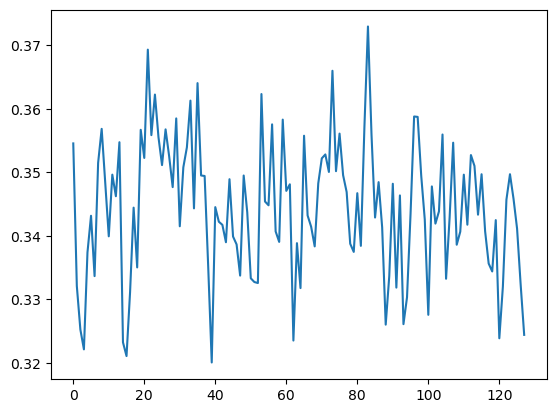

In [173]:
plt.plot(ex_X[:,-1,0])

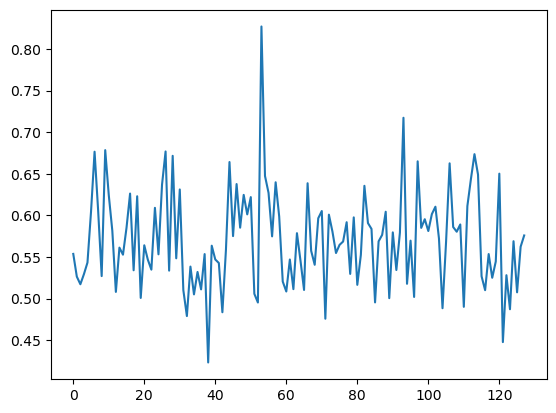

In [174]:
plt.plot(dec(enc(ex_X.to(torch.float32).to(device))).cpu().numpy()[:,0])

In [175]:
class StateTransition(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.transition_fn = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )
        
    def forward(self, z, n_steps):
        for step_num in range(n_steps):
            z = self.transition_fn(z)
            
        return z

In [176]:
ex_z = enc(ex_X.to(torch.float32).to(device))

In [177]:
transition = StateTransition(dim, hidden_dim=64).to(device)
transition(ex_z, 1)

tensor([[ 5.2545e-01, -1.0571e-01, -4.4725e-01],
        [ 5.3290e-01, -9.7609e-02, -3.5281e-01],
        [ 1.0504e-01, -1.8740e-02, -4.7309e-02],
        [ 3.6503e-01, -1.1932e-01, -2.5882e-01],
        [ 5.7699e-01, -9.2224e-02, -3.4933e-01],
        [ 4.8037e-01, -3.1038e-02, -2.5733e-01],
        [ 5.1755e-02, -1.1841e-01,  1.2858e-02],
        [ 7.7657e-01, -2.0119e-01, -6.6163e-01],
        [ 9.0032e-01, -1.2836e-01, -7.1580e-01],
        [ 6.6685e-01, -1.5824e-01, -5.1424e-01],
        [ 7.1991e-01, -1.4458e-01, -5.7013e-01],
        [ 9.9721e-01, -1.8171e-01, -7.4005e-01],
        [ 3.2733e-01, -1.3037e-01, -2.3664e-01],
        [ 6.4387e-01, -1.1713e-01, -5.1368e-01],
        [ 9.1080e-01, -2.4740e-01, -7.5729e-01],
        [ 1.2274e+00, -1.7333e-01, -9.7246e-01],
        [ 5.7510e-01, -1.7513e-01, -6.1212e-01],
        [ 7.3801e-01, -1.8353e-01, -4.9035e-01],
        [ 3.7204e-01, -7.8930e-02, -2.4728e-01],
        [ 6.9569e-01, -1.1551e-01, -5.8897e-01],
        [ 7.3217e-01

In [194]:
objective = nn.MSELoss()
transition = StateTransition(dim, hidden_dim=256).to(device)
params = transition.parameters()
    # optimizer
optim = torch.optim.Adam(params, lr=1e-3)
losses = []

n_epochs = 100

for epoch_num in tqdm(range(n_epochs)):
    done = False
    for i, (X, y) in enumerate(trainloader):
        if i > 3:
            done = True
            
        if not done:
            optim.zero_grad()
            X = X.to(torch.float32).to(device)
            n_steps = int(np.random.uniform(1, 20))
            n_steps = 1
            while i * trainloader.batch_size + n_steps-1 > len(trainloader):
                n_steps -= 1
                if n_steps == 1:
                    continue # is this right?
                
            valid_steps = y > n_steps
            valid_steps = valid_steps.squeeze()
            
            future_data = trainloader.dataset[i * X.shape[0] + n_steps : (i + 1) * X.shape[0] + n_steps][0]
            
            z = enc(X[valid_steps.squeeze(),:,:])
            z.requires_grad_(True)
            next_z = transition(z, n_steps)
            xhat = dec(next_z)
            
            true_future = torch.tensor(future_data[valid_steps, -1, :], requires_grad=True).to(torch.float32).to(device)
            loss = objective(xhat, true_future) # how do we get the data ahead in time?
            loss.backward()
            optim.step()
            
            first_params = next(iter(transition.parameters()))
            # print(f'Parameter: {first_params.data[:,0]}')
            losses.append(loss.item())
        
    print(f"Epoch: {epoch_num+1}, loss: {np.mean(losses[-100:])}")

  1%|          | 1/100 [00:00<00:36,  2.71it/s]

Epoch: 1, loss: 0.03409564308822155


  2%|▏         | 2/100 [00:00<00:35,  2.77it/s]

Epoch: 2, loss: 0.030864303931593895


  3%|▎         | 3/100 [00:01<00:34,  2.78it/s]

Epoch: 3, loss: 0.02956627185146014


  4%|▍         | 4/100 [00:01<00:34,  2.77it/s]

Epoch: 4, loss: 0.02876697643660009


  5%|▌         | 5/100 [00:01<00:33,  2.83it/s]

Epoch: 5, loss: 0.028276920411735774


  6%|▌         | 6/100 [00:02<00:33,  2.83it/s]

Epoch: 6, loss: 0.027870732126757503


  7%|▋         | 7/100 [00:02<00:32,  2.86it/s]

Epoch: 7, loss: 0.027650231761591777


  8%|▊         | 8/100 [00:02<00:31,  2.89it/s]

Epoch: 8, loss: 0.027403131709434092


  9%|▉         | 9/100 [00:03<00:31,  2.90it/s]

Epoch: 9, loss: 0.027276933814088505


 10%|█         | 10/100 [00:03<00:30,  2.91it/s]

Epoch: 10, loss: 0.02725520161911845


 11%|█         | 11/100 [00:03<00:30,  2.93it/s]

Epoch: 11, loss: 0.02719935482706536


 12%|█▏        | 12/100 [00:04<00:30,  2.93it/s]

Epoch: 12, loss: 0.027179987635463476


 13%|█▎        | 13/100 [00:04<00:29,  2.93it/s]

Epoch: 13, loss: 0.027123545260670092


 14%|█▍        | 14/100 [00:04<00:29,  2.94it/s]

Epoch: 14, loss: 0.027077951435265795


 15%|█▌        | 15/100 [00:05<00:29,  2.89it/s]

Epoch: 15, loss: 0.026965049157540003


 16%|█▌        | 16/100 [00:05<00:29,  2.83it/s]

Epoch: 16, loss: 0.02692732951254584


 17%|█▋        | 17/100 [00:05<00:29,  2.84it/s]

Epoch: 17, loss: 0.026877609848537865


 18%|█▊        | 18/100 [00:06<00:28,  2.86it/s]

Epoch: 18, loss: 0.026858473403586283


 19%|█▉        | 19/100 [00:06<00:28,  2.89it/s]

Epoch: 19, loss: 0.026825104545997947


 20%|██        | 20/100 [00:06<00:27,  2.90it/s]

Epoch: 20, loss: 0.026815173448994756


 21%|██        | 21/100 [00:07<00:27,  2.92it/s]

Epoch: 21, loss: 0.026788556039155947


 22%|██▏       | 22/100 [00:07<00:26,  2.92it/s]

Epoch: 22, loss: 0.026746853191236205


 23%|██▎       | 23/100 [00:07<00:26,  2.92it/s]

Epoch: 23, loss: 0.026719535539007706


 24%|██▍       | 24/100 [00:08<00:26,  2.88it/s]

Epoch: 24, loss: 0.026677815709263086


 25%|██▌       | 25/100 [00:08<00:25,  2.90it/s]

Epoch: 25, loss: 0.02666288185864687


 26%|██▌       | 26/100 [00:09<00:25,  2.91it/s]

Epoch: 26, loss: 0.026377950068563222


 27%|██▋       | 27/100 [00:09<00:25,  2.85it/s]

Epoch: 27, loss: 0.026320040114223956


 28%|██▊       | 28/100 [00:09<00:25,  2.84it/s]

Epoch: 28, loss: 0.026303018163889646


 29%|██▉       | 29/100 [00:10<00:25,  2.81it/s]

Epoch: 29, loss: 0.026304308772087098


 30%|███       | 30/100 [00:10<00:24,  2.80it/s]

Epoch: 30, loss: 0.026259013898670674


 31%|███       | 31/100 [00:10<00:24,  2.79it/s]

Epoch: 31, loss: 0.02628458457067609


 32%|███▏      | 32/100 [00:11<00:24,  2.79it/s]

Epoch: 32, loss: 0.02626978261396289


 33%|███▎      | 33/100 [00:11<00:23,  2.83it/s]

Epoch: 33, loss: 0.026287134513258936


 34%|███▍      | 34/100 [00:11<00:23,  2.86it/s]

Epoch: 34, loss: 0.026275693345814942


 35%|███▌      | 35/100 [00:12<00:22,  2.88it/s]

Epoch: 35, loss: 0.026264926437288522


 36%|███▌      | 36/100 [00:12<00:21,  2.92it/s]

Epoch: 36, loss: 0.02625885995104909


 37%|███▋      | 37/100 [00:12<00:21,  2.94it/s]

Epoch: 37, loss: 0.026244507413357498


 38%|███▊      | 38/100 [00:13<00:21,  2.94it/s]

Epoch: 38, loss: 0.026256663296371698


 39%|███▉      | 39/100 [00:13<00:20,  2.93it/s]

Epoch: 39, loss: 0.02626139808446169


 40%|████      | 40/100 [00:13<00:20,  2.93it/s]

Epoch: 40, loss: 0.026293127909302712


 41%|████      | 41/100 [00:14<00:20,  2.85it/s]

Epoch: 41, loss: 0.02631198091432452


 42%|████▏     | 42/100 [00:14<00:20,  2.82it/s]

Epoch: 42, loss: 0.02635487336665392


 43%|████▎     | 43/100 [00:14<00:19,  2.85it/s]

Epoch: 43, loss: 0.026357673574239016


 44%|████▍     | 44/100 [00:15<00:19,  2.82it/s]

Epoch: 44, loss: 0.026388291176408528


 45%|████▌     | 45/100 [00:15<00:19,  2.82it/s]

Epoch: 45, loss: 0.026370800230652094


 46%|████▌     | 46/100 [00:16<00:19,  2.82it/s]

Epoch: 46, loss: 0.026384720988571645


 47%|████▋     | 47/100 [00:16<00:18,  2.80it/s]

Epoch: 47, loss: 0.026351994145661594


 48%|████▊     | 48/100 [00:16<00:18,  2.81it/s]

Epoch: 48, loss: 0.026323762144893407


 49%|████▉     | 49/100 [00:17<00:18,  2.79it/s]

Epoch: 49, loss: 0.026377207078039647


 50%|█████     | 50/100 [00:17<00:17,  2.80it/s]

Epoch: 50, loss: 0.026407655011862517


 51%|█████     | 51/100 [00:17<00:17,  2.84it/s]

Epoch: 51, loss: 0.02636752210557461


 52%|█████▏    | 52/100 [00:18<00:17,  2.80it/s]

Epoch: 52, loss: 0.026360547244548796


 53%|█████▎    | 53/100 [00:18<00:16,  2.83it/s]

Epoch: 53, loss: 0.026352301761507987


 54%|█████▍    | 54/100 [00:18<00:16,  2.86it/s]

Epoch: 54, loss: 0.02633965661749244


 55%|█████▌    | 55/100 [00:19<00:15,  2.83it/s]

Epoch: 55, loss: 0.026387817189097405


 56%|█████▌    | 56/100 [00:19<00:15,  2.85it/s]

Epoch: 56, loss: 0.026367644295096398


 57%|█████▋    | 57/100 [00:19<00:14,  2.87it/s]

Epoch: 57, loss: 0.026339179798960687


 58%|█████▊    | 58/100 [00:20<00:14,  2.89it/s]

Epoch: 58, loss: 0.026364180818200113


 59%|█████▉    | 59/100 [00:20<00:14,  2.89it/s]

Epoch: 59, loss: 0.026369974296540023


 60%|██████    | 60/100 [00:20<00:13,  2.90it/s]

Epoch: 60, loss: 0.02634679889306426


 61%|██████    | 61/100 [00:21<00:13,  2.90it/s]

Epoch: 61, loss: 0.026329357456415892


 62%|██████▏   | 62/100 [00:21<00:13,  2.91it/s]

Epoch: 62, loss: 0.02631175048649311


 63%|██████▎   | 63/100 [00:21<00:12,  2.91it/s]

Epoch: 63, loss: 0.026285301651805638


 64%|██████▍   | 64/100 [00:22<00:12,  2.93it/s]

Epoch: 64, loss: 0.026280562710016966


 65%|██████▌   | 65/100 [00:22<00:12,  2.89it/s]

Epoch: 65, loss: 0.026284887809306382


 66%|██████▌   | 66/100 [00:23<00:11,  2.84it/s]

Epoch: 66, loss: 0.026243685763329267


 67%|██████▋   | 67/100 [00:23<00:11,  2.87it/s]

Epoch: 67, loss: 0.026202237270772456


 68%|██████▊   | 68/100 [00:23<00:11,  2.83it/s]

Epoch: 68, loss: 0.02618530310690403


 69%|██████▉   | 69/100 [00:24<00:11,  2.79it/s]

Epoch: 69, loss: 0.026163330506533383


 70%|███████   | 70/100 [00:24<00:10,  2.84it/s]

Epoch: 70, loss: 0.02616523377597332


 71%|███████   | 71/100 [00:24<00:10,  2.87it/s]

Epoch: 71, loss: 0.026104593817144632


 72%|███████▏  | 72/100 [00:25<00:09,  2.90it/s]

Epoch: 72, loss: 0.026149504892528055


 73%|███████▎  | 73/100 [00:25<00:09,  2.85it/s]

Epoch: 73, loss: 0.026183524820953607


 74%|███████▍  | 74/100 [00:25<00:09,  2.88it/s]

Epoch: 74, loss: 0.02615203632041812


 75%|███████▌  | 75/100 [00:26<00:08,  2.91it/s]

Epoch: 75, loss: 0.026149455681443213


 76%|███████▌  | 76/100 [00:26<00:08,  2.92it/s]

Epoch: 76, loss: 0.026135057490319014


 77%|███████▋  | 77/100 [00:26<00:07,  2.93it/s]

Epoch: 77, loss: 0.026113072372972966


 78%|███████▊  | 78/100 [00:27<00:07,  2.93it/s]

Epoch: 78, loss: 0.02610291002318263


 79%|███████▉  | 79/100 [00:27<00:07,  2.93it/s]

Epoch: 79, loss: 0.026106194164603948


 80%|████████  | 80/100 [00:27<00:06,  2.94it/s]

Epoch: 80, loss: 0.026085789613425732


 81%|████████  | 81/100 [00:28<00:06,  2.94it/s]

Epoch: 81, loss: 0.026103389691561462


 82%|████████▏ | 82/100 [00:28<00:06,  2.94it/s]

Epoch: 82, loss: 0.02611658589914441


 83%|████████▎ | 83/100 [00:28<00:05,  2.86it/s]

Epoch: 83, loss: 0.026105658654123544


 84%|████████▍ | 84/100 [00:29<00:05,  2.88it/s]

Epoch: 84, loss: 0.026118509620428085


 85%|████████▌ | 85/100 [00:29<00:05,  2.84it/s]

Epoch: 85, loss: 0.026124117355793716


 86%|████████▌ | 86/100 [00:29<00:04,  2.87it/s]

Epoch: 86, loss: 0.02612444007769227


 87%|████████▋ | 87/100 [00:30<00:04,  2.88it/s]

Epoch: 87, loss: 0.02613228779286146


 88%|████████▊ | 88/100 [00:30<00:04,  2.89it/s]

Epoch: 88, loss: 0.02614200273528695


 89%|████████▉ | 89/100 [00:31<00:03,  2.87it/s]

Epoch: 89, loss: 0.026148729044944048


 90%|█████████ | 90/100 [00:31<00:03,  2.89it/s]

Epoch: 90, loss: 0.026172921638935805


 91%|█████████ | 91/100 [00:31<00:03,  2.90it/s]

Epoch: 91, loss: 0.026167196650058032


 92%|█████████▏| 92/100 [00:32<00:02,  2.91it/s]

Epoch: 92, loss: 0.02618788605555892


 93%|█████████▎| 93/100 [00:32<00:02,  2.91it/s]

Epoch: 93, loss: 0.026168984137475492


 94%|█████████▍| 94/100 [00:32<00:02,  2.91it/s]

Epoch: 94, loss: 0.026182187926024197


 95%|█████████▌| 95/100 [00:33<00:01,  2.92it/s]

Epoch: 95, loss: 0.026205767188221218


 96%|█████████▌| 96/100 [00:33<00:01,  2.92it/s]

Epoch: 96, loss: 0.026228572893887758


 97%|█████████▋| 97/100 [00:33<00:01,  2.92it/s]

Epoch: 97, loss: 0.026244478486478328


 98%|█████████▊| 98/100 [00:34<00:00,  2.93it/s]

Epoch: 98, loss: 0.026245763041079045


 99%|█████████▉| 99/100 [00:34<00:00,  2.85it/s]

Epoch: 99, loss: 0.026241078861057757


100%|██████████| 100/100 [00:34<00:00,  2.87it/s]

Epoch: 100, loss: 0.02621761193498969


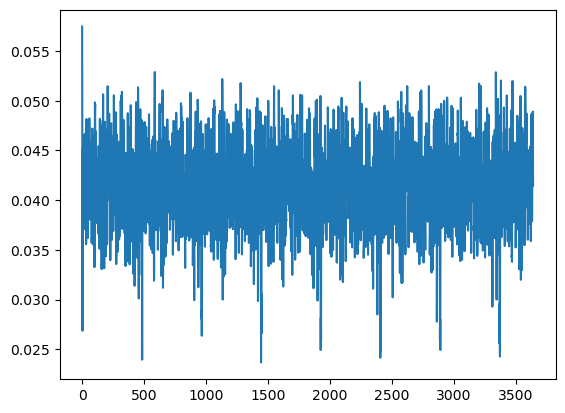

In [181]:
plt.plot(losses)